## Part 3: Data Exploration & Evaluation

**Author: John Min  
Date: November 24, 2019**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.discrete.discrete_model as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from patsy import dmatrices

import warnings
warnings.filterwarnings('ignore')

In [2]:
cols = ['loan_amnt', 
        'funded_amnt', 
        'term', 
        'int_rate', 
        'grade', 
        'annual_inc', 
        'issue_d', 
        'dti', 
        'revol_bal', 
        'total_pymnt', 
        'loan_status'] 

data = pd.read_csv('../data/loan.csv', usecols = cols)\
    .query("term == ' 36 months'")\
    .assign(issue_year = lambda x: x['issue_d'].apply(lambda x: int(x.split('-')[1])))\
    .query("issue_year < 2016")\
    .assign(default_status = lambda x: (~x['loan_status'].str.contains('Fully Paid')).astype(int))\
    .dropna(how='any')

In [3]:
data.shape

(621163, 13)

We drop any rows where any field contains a missing value, which results in the dropping of 6 observations

### Feature Engineering & Preprocessing

In [4]:
data['fund_ratio'] = data['funded_amnt'] / data['loan_amnt']
data['revol_income_ratio'] = data['revol_bal'] / data['annual_inc']
data['revol_loan_ratio'] = data['revol_bal'] / data['funded_amnt']

In [5]:
variables = ['default_status', 'funded_amnt', 'int_rate', 'annual_inc', 'dti', 
             'issue_year', 'revol_income_ratio', 'revol_loan_ratio', 'fund_ratio']

features = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'issue_year', 
            'revol_income_ratio', 'revol_loan_ratio', 'fund_ratio']

#### Pairwise Correlation

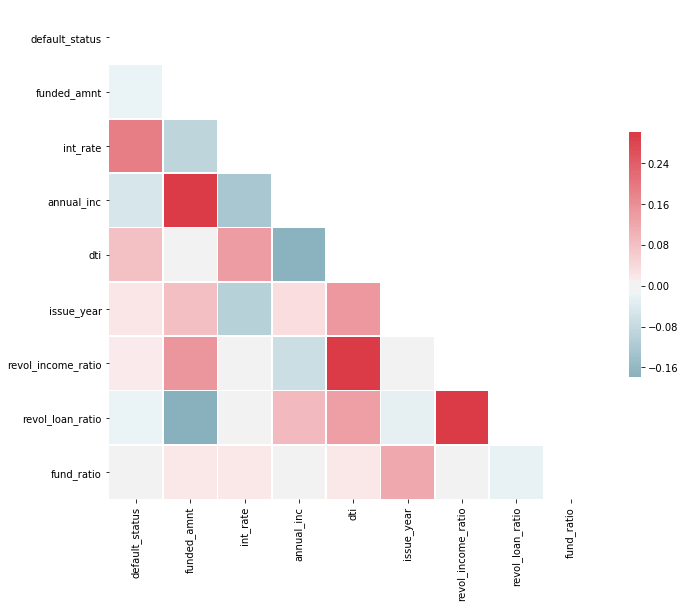

In [6]:
corr = data[variables]._get_numeric_data().corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

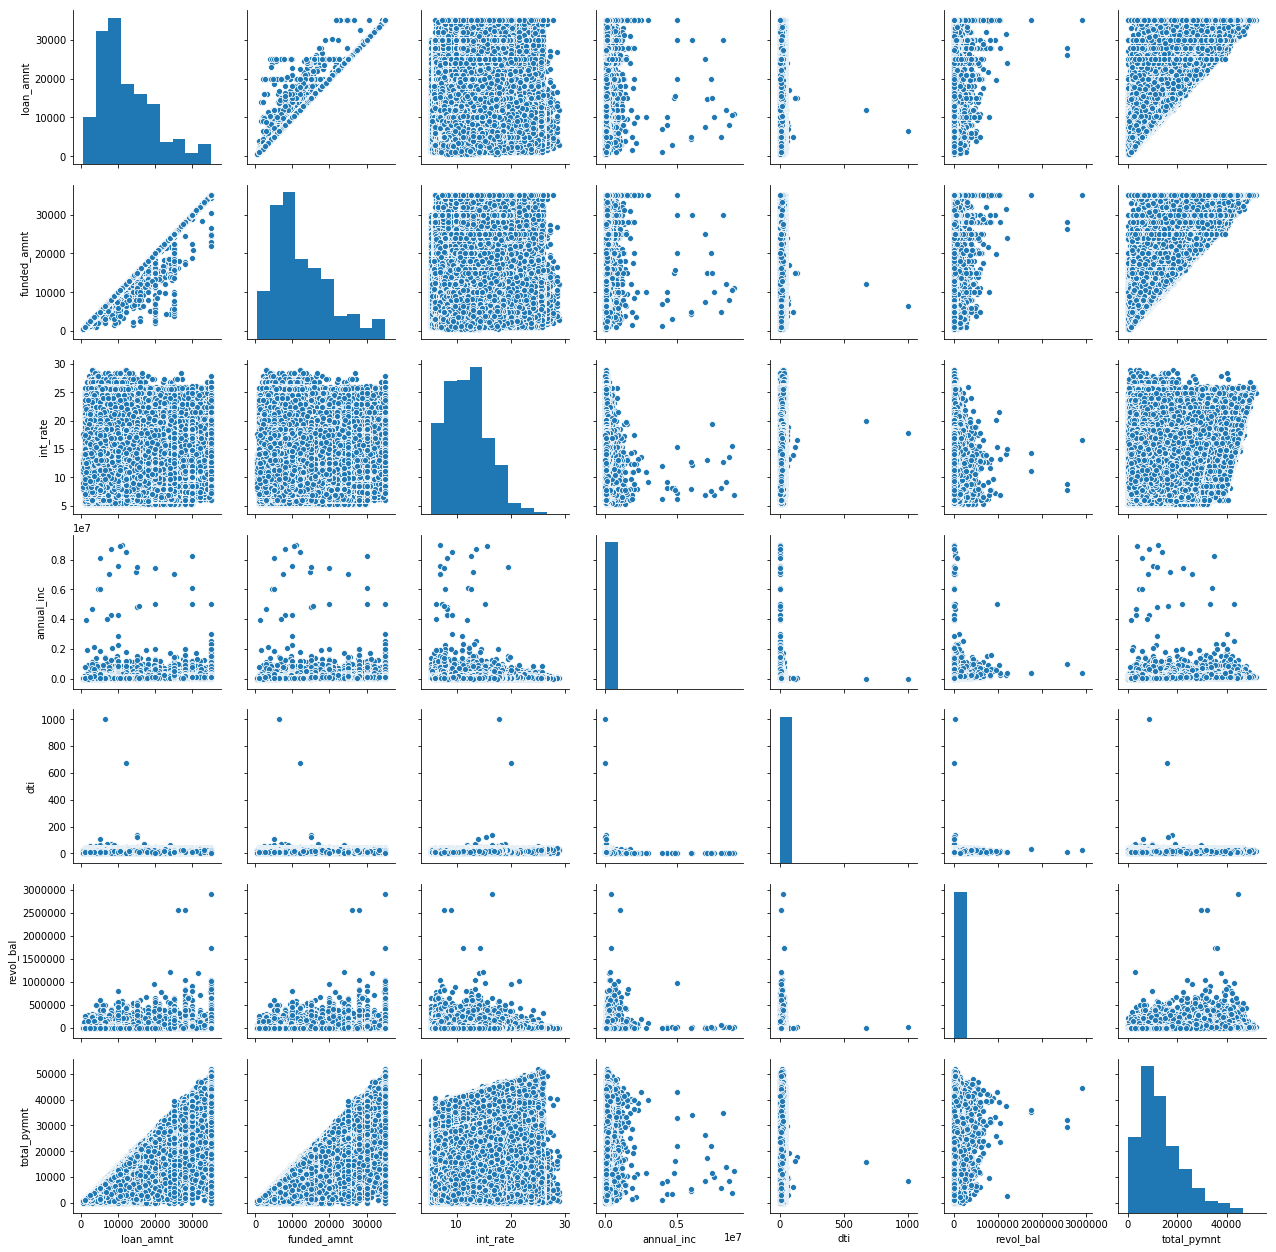

In [7]:
sns.pairplot(data[cols]._get_numeric_data())

#### Comparing the Dependent with Independent Variables

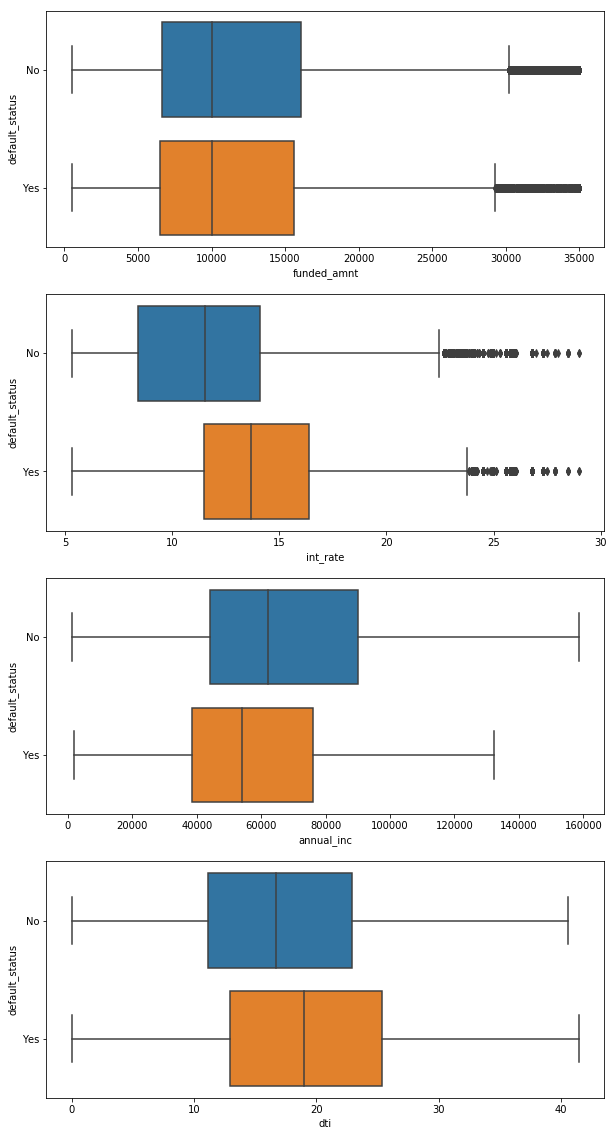

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(10, 20)
sns.boxplot(x = data['funded_amnt'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), ax=ax1)
sns.boxplot(x = data['int_rate'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), ax=ax2)
sns.boxplot(x = data['annual_inc'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), 
            ax=ax3, showfliers=False)
sns.boxplot(x = data['dti'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), 
            ax=ax4, showfliers=False)

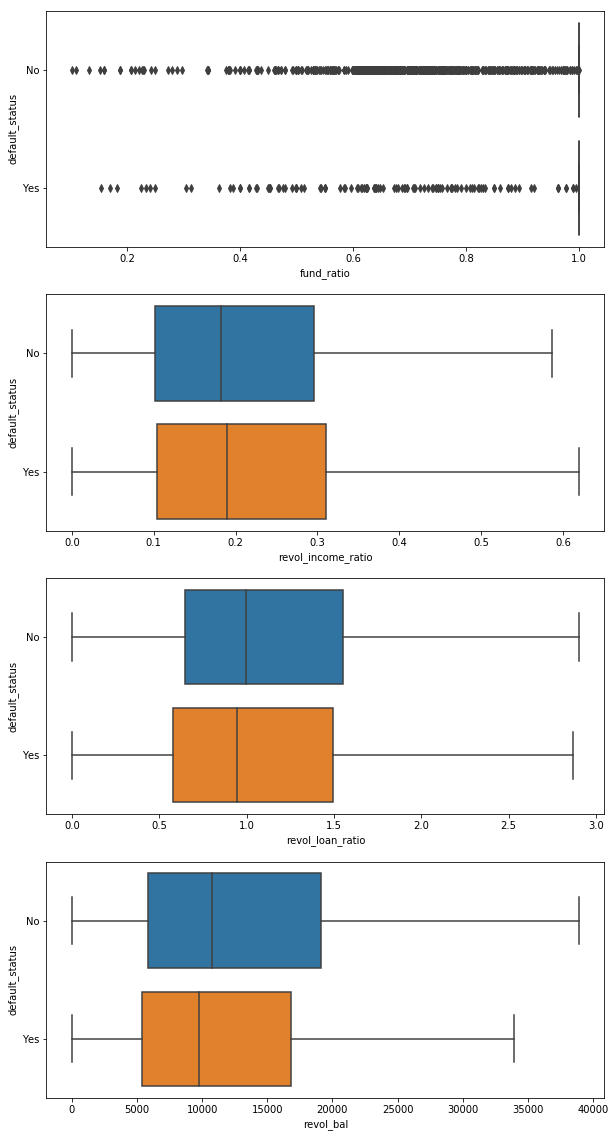

In [9]:
fig, (ax5, ax6, ax7, ax8) = plt.subplots(4)
fig.set_size_inches(10,20)
sns.boxplot(x = data['fund_ratio'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), ax=ax5)
sns.boxplot(x = data['revol_income_ratio'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), 
            ax=ax6, showfliers=False)
sns.boxplot(x = data['revol_loan_ratio'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), 
            ax=ax7, showfliers=False)
sns.boxplot(x = data['revol_bal'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'), 
            ax=ax8, showfliers=False)

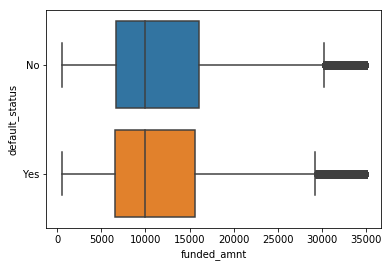

In [10]:
sns.boxplot(x = data['funded_amnt'], y = data['default_status'].apply(lambda x: 'Yes' if x == 1 else 'No'))

#### Splitting DV & IV

In [11]:
X = data[features].drop(['issue_year'], axis=1)
y = data['default_status']

'''
model_formula = """default_status ~ funded_amnt + int_rate + annual_inc + dti + 
    issue_year + revol_income_ratio + revol_loan_ratio + fund_ratio"""

y, X = dmatrices(model_formula, data)
''';

#### Check for Multicollinearity using Variance Inflation Factor Anaylsis

In [12]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [13]:
vif

,VIF Factor,features
0,4.935446,funded_amnt
1,11.104143,int_rate
2,2.824724,annual_inc
3,6.372342,dti
4,3.938203,revol_income_ratio
5,2.261253,revol_loan_ratio
6,18.785487,fund_ratio


We only included features that did not present any issues with multicollinearity. Generally, if the VIF is between 5 and 10, the variable should be considered for dropping. In this case, we decided to keep interest rate and debt-to-income ratio after the following plot

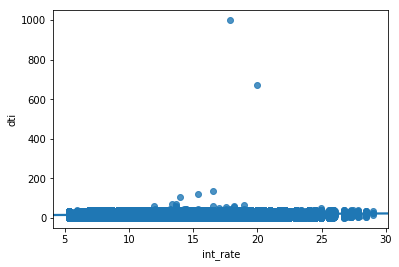

In [14]:
sns.regplot(data['int_rate'], data['dti'])

### Model Building & Fitting

#### 80-20 Split into Training & Testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=14)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((496930, 7), (124233, 7), (496930,), (124233,))

We use statsmodels to implement the logistic regression

In [17]:
logit = sm.Logit(y_train, X_train)
fit = logit.fit()
pred = fit.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.384982
         Iterations 7


In [18]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         default_status   No. Observations:               496930
Model:                          Logit   Df Residuals:                   496923
Method:                           MLE   Df Model:                            6
Date:                Sun, 24 Nov 2019   Pseudo R-squ.:                 0.04848
Time:                        08:10:10   Log-Likelihood:            -1.9131e+05
converged:                       True   LL-Null:                   -2.0106e+05
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
funded_amnt         2.731e-06   7.46e-07      3.661      0.000    1.27e-06    4.19e-06
int_rate               0.1294      0.001    119.923      0.000       0.127       0.132
annual_inc         -2.236e-06    1.4e-07    -15.986      0.000   -2.51e-06   -1.96e-06
dti                    0.0182      0.001     33.747      0.000       0.017       0.019
revol_income_ratio     0.0331      0.030      1.100      0.271      -0.026       0.092
revol_loan_ratio      -0.0339      0.003    -11.164      0.000      -0.040      -0.028
fund_ratio            -3.6390      0.020   -178.739      0.000      -3.679      -3.599
======================================================================================
"""

Every feature was statistically significant with the exception of the Revolving Balance - Income Ratio.

#### Compute ROC & AUC

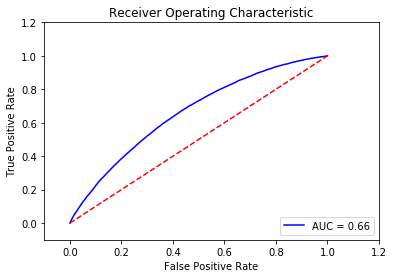

In [19]:
# Compute ROC metrics
fp, tp, thresholds = roc_curve(y_test, pred, pos_label=1)
roc_auc = auc(fp, tp)

# Plot ROC curve
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fp, tp, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0, 0.5, 'True Positive & False Positive Rates')

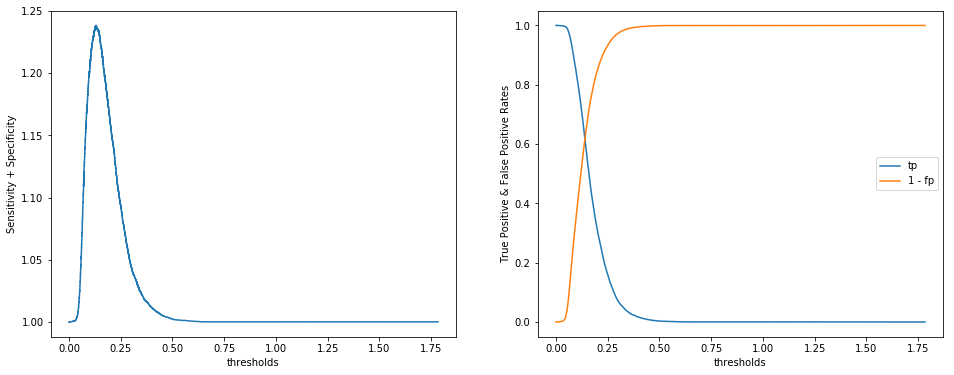

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(thresholds, tp + (1 - fp))
ax[0].set_xlabel('thresholds')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(thresholds, tp, label="tp")
ax[1].plot(thresholds, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('thresholds')
ax[1].set_ylabel('True Positive & False Positive Rates')

#### Determining Optimal Threshold = Intersection of True Positive & False Positive Rates

In [21]:
##finding the optimal threshold for the model
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = thresholds[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

optimal threshold: 0.13111342914341598


Basically, the optimal threshold is similar to the base rate / class weight.

In [22]:
data['default_status'].value_counts(normalize=True)

0    0.860199
1    0.139801
Name: default_status, dtype: float64

In [23]:
def binarize_by_threshold(values, threshold):
     return (np.where(values >= threshold, 1, 0))
    
y_pred = binarize_by_threshold(pred, optimal_threshold)
y_pred_14 = binarize_by_threshold(pred, 0.139801)

### Model Evaluation

#### Accuracy

Model is 58% accurate

In [24]:
(y_test == y_pred).value_counts(normalize=True)

True     0.582188
False    0.417812
Name: default_status, dtype: float64

#### Confusion Matrix

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    """
    from sklearn.utils.multiclass import unique_labels
        
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [26]:
y_test.value_counts()

0    106864
1     17369
Name: default_status, dtype: int64

In [27]:
confusion_matrix(y_test, y_pred)

array([[60681, 46183],
       [ 5723, 11646]])

In [28]:
pd.Series(y_pred).value_counts()

0    66404
1    57829
dtype: int64

Confusion matrix, without normalization
[[60681 46183]
 [ 5723 11646]]


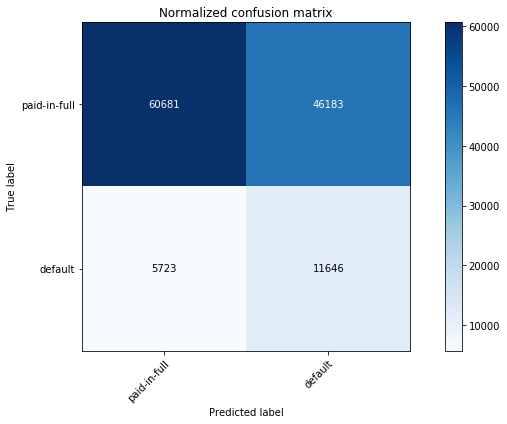

In [29]:
class_names = ['paid-in-full', 'default']
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

Normalized confusion matrix
[[0.56783388 0.43216612]
 [0.32949508 0.67050492]]


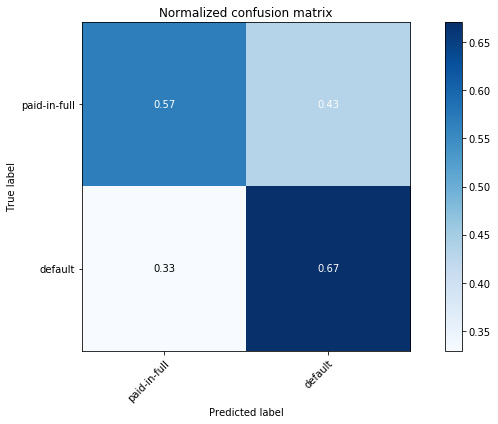

In [30]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Beyond accuracy, the confusion matrix gives us additional insight, particularly around the false positive and false negative classifications.

## Was the model effective?

In summary, the model is so-so; it is not bad, but certainly not great. The area under the curve (AUC) is 0.66, where we are plotting the true positive rate against the false positive rate. In our confusion matrix, we observe that the model has a 67.1% accuracy with respect to identifying loans that will default. However, the trade-off here is that the model grossly over-predicts "default. Thus, our overall model accuracy is only 58% and we have a 56.8% accuracy with respect to predicting "good" loans which represent 85% of the examples in the dataset. The problem with this model is that it would miss out on many opportunities to extend loans that would not have defaulted.

Next steps are clear. We need to determine some priorities with respect to how we want this model to be impemented. More time should be spent on feature engineering. Finally, we can try implementing some other modeling techniques such as a decision tree algorithms like XGBoost, whic has found great success in the Kaggle and data science competition space.